# Hybridation de GA_net avec reinforcement learning pour la résolution du problème de PDC


### Implémentation : DRIOUA Imed
**Equipe ONC ** 

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics.cluster import normalized_mutual_info_score
import collections
from itertools import product
import networkx.algorithms.community as nx_comm
import random

from scipy.stats import entropy
from scipy.special import softmax
import statistics as stc

# Fonction de la mutation


In [7]:
def mutate(chromosome, p):
    n = np.random.random_sample()
    if n < p:  # if random num is less than probability, mutate
        # The random value to be added to the gene.
        idx = int(np.random.uniform(0,10,1))
        random_value = int(np.random.uniform(0,10,1))
        chromosome[idx] =  random_value

    return chromosome

# Opérateurs de croisement

In [8]:
def uniform_crossover(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])
    
def uniform_crossover_1point(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.zeros(length,dtype=int)
        pos = np.random.randint(0,length)
        mask[pos]=1
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])
    
def uniform_crossover_2point(parent_1,parent_2,crossover_rate):
    if np.random.random_sample() < crossover_rate:
        length = len(parent_1)
        mask = np.zeros(length,dtype=int)
        pos1 = np.random.randint(0,length)
        pos2 = np.random.randint(0,length)
        mask[pos1]=1
        mask[pos2]=1
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=parent_1[i]
            else:
                child[i]=parent_2[i]
        return child
    else:
        return np.array([])   
    



def cxTwoPoint(ind1, ind2):
    
    size = min(len(ind1), len(ind2))
    cxpoint1 = np.random.randint(1, size)
    cxpoint2 = np.random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

    return ind1



# Fonction de selection des actions

In [9]:
def selection_policy(Q_row,action_size,beta,gen,it):
    if( it < ((2 * gen)/100)) :   ## Exploration (2% de nombre d'itération)
        return  random.randint(0, 3) 
    else :                        ## Eploitation
        return np.argmax(Q_row)

In [10]:
def find_chrom(subset,nodes_size):
    new_subset = []
    for s in subset:
        new_s = list(s)
        new_subset.append(new_s)
        
    chrom = []    
    for i in range(nodes_size):
        j = 0
        while (i not in new_subset[j]):
            j += 1
        ind =  (new_subset[j].index(i) + 1)%len(new_subset[j])
        chrom.append(new_subset[j][ind])   
    return chrom            
                

#  Fonction de selection des états


In [11]:
def get_state_mod(value):
    if(value < 0 ):
        if(abs(value) <=0.1 ):
            if(abs(value) <=0.05):
                return 0
            else :
                return 1
        else :
            return 2
            
    elif(value ==0) :
        return 3
    else :
        return 4

# Algorithme principal

In [28]:
def community_detection(nodes,edges,population=300,generation=30,nbrEpisode = 5, r=1.5): 
    
    graph=nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    Adj = nx.adjacency_matrix(graph)
    nodes_length = len(graph.nodes())
    nodes_list = list(graph.nodes())
    result = []
    modulari = []
     
    action_size = 4
    state_size = 5
    beta = 0.25 
    alpha = 0.3
    gamma = 0.2
    
    Q_table = np.zeros((state_size,action_size)) ## Initialisation de la Q_table
    
  
    ################################ Génération de la population initiale ################################
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
    dframe = pd.DataFrame(data= d)

    subsets = dframe["chrom"].apply(find_subsets)
    dframe["subsets"] = subsets
   
    
    for i in range (dframe.shape[0]):
        result = []
        row = dframe.iloc [i , :]
        chrom = row["chrom"]
        for subs in row["subsets"]:
            subset = []
            for n in subs:
                subset.append(nodes_list[n])
            result.append(subset)
        modulari.append (modularity(graph,np.array(result)))
        #print (modularity(graph,np.array(result)))
    dframe["modularity"] = np.array(modulari)
    #print (modulari)
    mod_init= max(dframe["modularity"])
    ################################ Fin Génération de la population initiale + fitness ################################
    gen = 0
    population_count = population
    pop_best = max(dframe["modularity"])
    k = 0
    state = 3 ## On commence par l'état 3 qui représente -- il y a aucun gain --
   

    
    ################################ Boucle principale ################################
    resu = []
    while gen < generation :
        qlearning = 0
        children_mod = []
        max_modularite_pop = max(dframe["modularity"])
        ## Boucle des épisodes##################################################
        while  qlearning < nbrEpisode:
        
         
          old_pop = dframe.copy()
          pop_best = max(old_pop["modularity"])
              
        ################################ générer population/10 enfants "M"  ################################ 
          for i in range(int(np.floor(population/10))+50):
              old =  max(dframe["modularity"])
      
              ## ordonner selon modularity
              elites = dframe.sort_values("modularity",ascending=True)[int(np.floor(population/10)):]
                                 
              p1 = roulette_selection(elites)
              p2 = roulette_selection(elites)
              
              ### Croisement ##
              its = (int(np.floor(population/10))+50)* generation * nbrEpisode 
              it= (((gen * nbrEpisode) + qlearning) * (int(np.floor(population/10))+50) )+i  
              ##Choisir l'action
            
              action = selection_policy(Q_table[state],action_size,beta,its,it)  
              
              if(action == 0):
                  child=uniform_crossover(dframe["chrom"][p1],dframe["chrom"][p2],1)
                  
              elif(action == 1): 
                  child=cxTwoPoint(dframe["chrom"][p1],dframe["chrom"][p2])
                  
              elif(action == 2): 
                  child=uniform_crossover_1point(dframe["chrom"][p1],dframe["chrom"][p2],1) 
                  
              elif(action == 3): 
                  child=uniform_crossover_2point(dframe["chrom"][p1],dframe["chrom"][p2],1)
              if len(child)==0:
                  continue           
              child=mutate(child, 0.2)
              child_subsets = find_subsets(child)
              #child_cs = community_score(child,child_subsets,r,Adj)
              result = []
              for subs in child_subsets:
                  subset = []
                  for n in subs:
                      subset.append(nodes_list[n])
                  result.append(subset)   
              child_mod = modularity(graph,np.array(result))
              #print("p1 = ",dframe["modularity"][p1] ,"p2 = ",dframe["modularity"][p2], "child = ",child_mod)
              #print("child_mod = ",child_mod)
              value =  child_mod -  max(dframe["modularity"])
              dframe.loc[population_count]=[child,child_subsets,child_mod]
              children_mod.append(child_mod)
              maxPrents = max(dframe["modularity"][p1],dframe["modularity"][p2]) 
              rm = child_mod - maxPrents
              """
              Au cas y aurait heuristiques on ajoute une pénamisation avec le temps de l'exécution
              if(action >= 4) :
                  #rm -= 1 / (1 + np.exp(-duree))
              """    
              if(rm <= 0) :
                  rm -= 0.5  
                  
              new_state = get_state_mod(value)
              #Mise à jour de la table Q_learning
                
              Q_table[state][action] = (1-alpha)*Q_table[state][action] + alpha*(rm + gamma*max(Q_table[new_state]))
              state = new_state
              
              population_count += 1
               

          #### Remplacement
          dfsorted = dframe.sort_values("modularity",ascending=False)
          to_drop = dfsorted.index[population:]
          dframe.drop(to_drop,inplace=True)
          qlearning+=1
                
        maxPop = max(old_pop["modularity"])
          
        gen +=1   
        new_pop_best = max(dframe["modularity"])

        
    ################################ Fin Boucle principale ################################  
    
    
   ################################  Calculer la meilleur solution dans la pop  ################################ 
    sorted_df = dframe.sort_values("modularity",ascending=False).index[0]
    result = []
    modulari = []
    for i in range (dframe.shape[0]):
        result = []
        row = dframe.iloc [i , :]
        chrom = row["chrom"]
        for subs in row["subsets"]:
            subset = []
            for n in subs:
                subset.append(nodes_list[n])
            result.append(subset)
        #print("ici")
        modulari.append (modularity(graph,np.array(result)))
    dframe["modularity"] = np.array(modulari)
    nodes_subsets = dframe["subsets"][sorted_df]
    nodes_list = list(graph.nodes())
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    #print("Q table :  ",Q_table)

    ################################ Fin  Calculer la meilleur solution dans la pop  ################################  

    return max( dframe["modularity"]) 

def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom

def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(result):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    return result


def roulette_selection(df_elites):
    prob = np.random.random_sample()
    sum_cs=np.sum(df_elites["modularity"])
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["modularity"][i]
        X=x/sum_cs
        if prob < X:
            chosen=i
            break
    return chosen


def modularity(G, partition):
    """Returns the modularity of the partition of an undirected graph G."""
    #print(dict(partition))
    #print(partition)
    partitions = [set(partition[i]) for i in range (partition.shape[0])]
    if is_partition(G,partitions):
        mod = nx_comm.modularity(G, partitions)
    else :
        mod = 0
    return mod


In [19]:
def is_partition(N,C):

    for n in N:
        aff = affiliation(n,C)
        if not len(aff) == 1:
            return False
    return True

def affiliation(n,C):

    aff = []
    i = 0
    for c in C:
        if n in c:
            aff.append(i)
        i+=1
    return aff

In [20]:
import matplotlib.pyplot as plt

def draw_graph(H,node_size = 200):
    N = H.nodes
    E = H.edges
    return community_detection(N,E)


In [21]:
def draw_plot(mod):
    plt.figure(figsize=(20,10))
    plt.plot(mod)
    #plt.xlabel('Episodes') 
    #plt.ylabel('Nombre des etapes') 
    #plt.legend()
    plt.show()

# Tests

# 1- Football


In [22]:
G = nx.read_gml("data/football.gml",label="id")
print("Modularité finale :",draw_graph(G, node_size = 300) )


Q table :   [[-0.69778789 -0.66573558 -0.6345608  -0.6628486 ]
 [-0.67947922 -0.69152707 -0.68517221 -0.62932   ]
 [-0.70497338 -0.71917816 -0.70143445 -0.63950978]
 [-0.64908676 -0.6331308  -0.64835161 -0.64917066]
 [-0.39539183 -0.41386535 -0.44612255 -0.38647975]]
Modularité finale : 0.539147721073319


# Karate

In [23]:
G = nx.read_gml("data/karate.gml",label="id")
print("Modularité finale :",draw_graph(G, node_size = 300) )

Q table :   [[-0.78735655 -0.76889615 -0.63803    -0.75636594]
 [-0.63277499 -0.74545621 -0.76444912 -0.74562759]
 [-0.72175219 -0.71523348 -0.65105259 -0.73007442]
 [-0.7175606  -0.72206706 -0.73672182 -0.64781163]
 [-0.1812465  -0.18089664 -0.18877968 -0.1775392 ]]
Modularité finale : 0.41978961209730437


# Dolphins

In [24]:
G = nx.read_gml("data/dolphins.gml",label="id")
print("Modularité finale :",draw_graph(G, node_size = 300) )

Q table :   [[-0.71263102 -0.747071   -0.70742013 -0.62776543]
 [-0.76731455 -0.72114377 -0.72014761 -0.64129225]
 [-0.70259718 -0.70977136 -0.63132204 -0.72478565]
 [-0.67102907 -0.67332281 -0.67274808 -0.62855396]
 [-0.49417249 -0.49724099 -0.48014113 -0.50414688]]
Modularité finale : 0.5285194414777896


# Polbooks

In [25]:
G = nx.read_gml("data/polbooks.gml",label="id")
print("Modularité finale :",draw_graph(G, node_size = 300) )

Q table :   [[-0.63107041 -0.81240546 -0.80338751 -0.80379089]
 [-0.64078527 -0.8017619  -0.78910667 -0.82197684]
 [-0.76151212 -0.76335574 -0.65044468 -0.7732655 ]
 [-0.64380138 -0.79395772 -0.80794043 -0.79570625]
 [-0.4366412  -0.48819999 -0.42797621 -0.47014563]]
Modularité finale : 0.5266452764023222


# Tests avec la plusieurs exécutions (On prend Moyenne - Min - Max)

## Polbooks


In [31]:
H = nx.read_gml("data/polbooks.gml",label="id")
mods = []
for i in range(10): # 10 exécutions
  mod = community_detection(H.nodes(),H.edges())
  mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.5256660033627963
Worst   =  0.5215316663324437
Best   =  0.5272365938060788


## Football

In [32]:
H = nx.read_gml("data/football.gml",label="id")
mods = []
for i in range(10): # 10 exécutions
  mod = community_detection(H.nodes(),H.edges())
  mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.554630105197608
Worst   =  0.5097932506406861
Best   =  0.5809260476516156


## Dolphins

In [33]:
H = nx.read_gml("data/dolphins.gml",label="id")
mods = []
for i in range(10): # 10 exécutions
  mod = community_detection(H.nodes(),H.edges())
  mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.5239468375459831
Worst   =  0.5181361496776236
Best   =  0.5285194414777896


# Tests avec Benchmarks

In [34]:
def read_data(file_name): ## Fonction pour lire les fichiers de type network.dat
    G = nx.Graph()
    with open(file_name, "r") as f:
        for line in f:
            if line[0] == "#":
                continue
            N1, N2 = map(int, line.split())
            weight = 1 
            G.add_edge(N1, N2)
    return G

# Graph 0.1

In [36]:
H = read_data("data/0.1/network.dat")
mods = []
for i in range(10):
    mod = community_detection(H.nodes(),H.edges())
    mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.64736328125
Worst   =  0.6153564453125
Best   =  0.65234375


# Graph 0.3

In [37]:
H = read_data("data/0.3/network.dat")
mods = []
for i in range(10):
    mod = community_detection(H.nodes(),H.edges())
    mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.27177734375
Worst   =  0.2384033203125
Best   =  0.310302734375


# Graph 0.6

In [38]:
H = read_data("data/0.6/network.dat")
mods = []
for i in range(10):
    mod = community_detection(H.nodes(),H.edges())
    mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.14066162109375
Worst   =  0.13037109375
Best   =  0.15283203125


# Graph 0.9

In [39]:
H = read_data("data/0.9/network.dat")
mods = []
for i in range(10):
    mod = community_detection(H.nodes(),H.edges())
    mods.append(mod)
    
print("Mean  = " ,np.mean(mods))
print("Worst   = " ,np.min(mods))
print("Best   = " ,np.max(mods))

Mean  =  0.1398193359375
Worst   =  0.1295166015625
Best   =  0.1533203125


# Tests Complémentaires

## 1. Utilisation d'un seul Operateur VS plusieurs lors de l'exécution de GA_NET

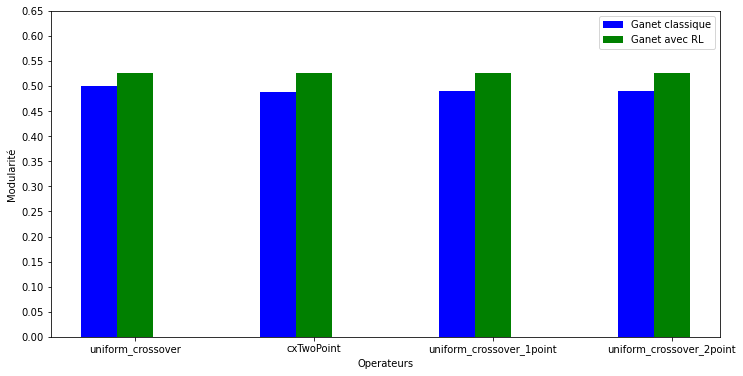

In [35]:
x = np.arange(0,8,2)
# Résultats de  Ga net classique pris pour chaque opérateur (à partir d'un autre notebook) sur le graphe polbooks
ganet =  [0.4993168998513994, 0.48899069832014436, 0.48916089489461695, 0.48916012361104677 ]
#Résultats de notre algorithme pris à partir des tests ci-dessus sur le meme graph
qlearn = [0.5250348363079169, 0.5250348363079169 , 0.5250348363079169, 0.5250348363079169 ]

width = 0.4
plt.figure(figsize=(12,6))  
plt.bar(x-0.4, ganet, width, color='blue')
plt.bar(x, qlearn, width, color='green')

plt.xticks(x, ['uniform_crossover', 'cxTwoPoint', 'uniform_crossover_1point', 'uniform_crossover_2point'])
plt.yticks(np.arange(0, 0.7, 0.05))
plt.xlabel("Operateurs")
plt.ylabel("Modularité")
plt.legend(["Ganet classique", "Ganet avec RL"])
plt.show()

## 2. Politique de choix aléatoire VS politique  basée sur le Q_learning

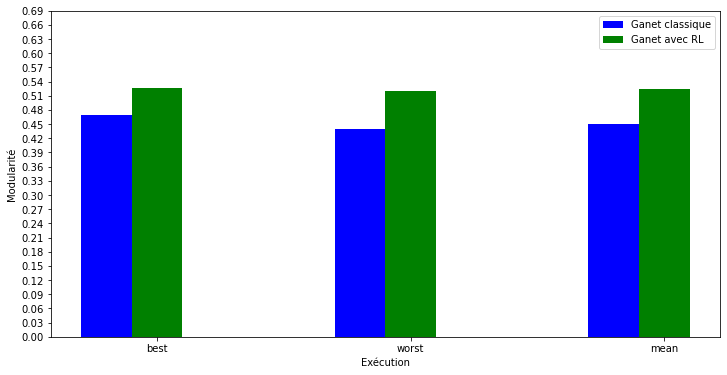

In [40]:
x = np.arange(3)
# Résultats de  Ga net classique avec choix aléatoire de l'operateur (graph Dolphins)
ganet = [0.46900489396411094 ,0.43985267544688356 ,0.45102549704738815]
# Résultats de notre algorithme sur le meme graph 
q_lern = [ 0.5269383641589667 , 0.5210303320118674 , 0.5250348363079169]

width = 0.2
plt.figure(figsize=(12, 6))
plt.bar(x-0.2, ganet, width, color='blue')
plt.bar(x, q_lern, width, color='green')

plt.xticks(x, ['best', 'worst', 'mean'])
plt.xlabel("Exécution")
plt.yticks(np.arange(0, 0.7, 0.03))
plt.ylabel("Modularité")
plt.legend(["Ganet classique", "Ganet avec RL"])
plt.show()